# Automatic Differentiation with PyTorch
Created by [Santiago Pascual](https://scholar.google.es/citations?user=7cVOyh0AAAAJ&hl=ca) ([UPC School](https://www.talent.upc.edu/ing/estudis/formacio/curs/310400/postgrau-artificial-intelligence-deep-learning/) 2019)

Updated by [Xavier Giro](https://imatge.upc.edu/web/people/xavier-giro) ([UPC TelecomBCN](https://telecombcn-dl.github.io/dlai-2019/) 2019) and [Gerard I. Gállego](https://www.linkedin.com/in/gerard-gallego/)

## Course material
* [Slides](https://www.slideshare.net/xavigiro/backpropagation-for-neural-networks) by [Xavier Giro](https://imatge.upc.edu/web/people/xavier-giro)
* [Video](https://www.youtube.com/watch?v=uub_hqDlqjc) by [Elisa Sayrol](https://imatge.upc.edu/web/people/elisa-sayrol)

This session will be about how to perform backpropagation in PyTorch. To build neural networks with PyTorch we must first understand how this framework simplifies our life. Central to all neural networks in PyTorch is the `autograd` package [1]. This package provides **automatic differentiation for all operations on Tensors**. *HOW COOL IS THAT?*

This means you can put layers and layers of operations over your PyTorch tensors, and the `autograd` package already computes the derivatives of those operations in the backprop process. It is a define-by-run framework, which means that your backprop is defined by how your code is run, and that every single iteration can be different. *Wow wow, wait... define-by-run? every single iteration can be different? What is all this jargon??* Let's see the following concepts during this tutorial:

* The `grad`s in our `tensor`s.
* The dynamic computational graph concept (DCG).
* The `.backward()` life saver.

In [1]:
# Imports that will be needed
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
from timeit import default_timer as timer

### Long Story Short

The `torch.Tensor` class has an attribute `.requires_grad`. If you set it to `True`, it **starts tracking all operations on it**. When you finish your computations you can call `.backward()` and have **all the gradients computed automatically**. The gradient for this tensor will be **accumulated** into the `.grad` attribute.

*IMPORTANT: Accumulated means it sums up the new gradients to the already existing ones (if any)!*

Any operation performed on a `Tensor` that conforms a `Function` (`torch.autograd.Function`) creates a new node of an acyclic graph. This means that each `Tensor` where it comes from (its source `Tensor` and the `Function` that created itself). The `Tensor` attribute `grad_fn` references the `Function` that created it. THAT SIMPLE.

Example multiplication of two tensors and the resulting interconnections [2]:

![img](https://miro.medium.com/max/336/1*jGo_2J9UQeynwG_3olUD4w.png)

Well this is the so called *dynamic computational graph (DCG)*.

#### Creating a tensor, operating on it, and computing derivatives

In [2]:
import torch

def describe_tensor(tensor, name=''):
  # Helper function to explore the attributes of a tensor object
  print('-' * 30)
  print('Name: ', name)
  print('-' * 30)
  print('data : ', tensor.data)
  print('requires_grad : ', tensor.requires_grad)
  print('grad: ', tensor.grad)
  print('grad_fn: ', tensor.grad_fn)
  print('is_leaf: ', tensor.is_leaf)
  print('=' * 30)


In [3]:
# create a tensor x
x = torch.tensor(1.0)
# create a tensor y
y = torch.tensor(2.0)

describe_tensor(x, name='x')
describe_tensor(y, name='y')

------------------------------
Name:  x
------------------------------
data :  tensor(1.)
requires_grad :  False
grad:  None
grad_fn:  None
is_leaf:  True
------------------------------
Name:  y
------------------------------
data :  tensor(2.)
requires_grad :  False
grad:  None
grad_fn:  None
is_leaf:  True


In [4]:
# Create z as the multiplicative outcome of x * y
z = x * y
describe_tensor(z, name='z')

------------------------------
Name:  z
------------------------------
data :  tensor(2.)
requires_grad :  False
grad:  None
grad_fn:  None
is_leaf:  True


We have created a DCG out of a simple product of two scalar tensors. But there is no node requiring gradients! Let's call the life saver `backward()` function.

In [5]:
z.backward()

RuntimeError: element 0 of tensors does not require grad and does not have a grad_fn

No hesitation, is was meant to crash. There is no `Tensor` requiring to track the graph because none required the gradients to be computed with `requires_grad=True`. Now we can make it require the gradients by simply using the inplace function `.require_gradients_(True)` or by specifying the flag as `True` at `Tensor` creation time.

In [6]:
# make x track gradients
x = torch.tensor(1.0, requires_grad=True)
z = x * y
describe_tensor(z)

------------------------------
Name:  
------------------------------
data :  tensor(2.)
requires_grad :  True
grad:  None
grad_fn:  <MulBackward0 object at 0x7a169ecf8280>
is_leaf:  False


<ipython-input-2-377bf9e939b1>:10: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /pytorch/build/aten/src/ATen/core/TensorBody.h:489.)
  print('grad: ', tensor.grad)


#### Note the change in the Tensor description!

Now there are two important differences from this `z` to the previous one. First, this one DOES require gradient tracking. But secondly, it contains a `grad_fn` reference to a `MulBackward` operation! Which is basically telling us that multiplication will go through a derivative process in the backward step when we call the `backward()` function.

In [7]:
# call .backward() now on z
z.backward()

# Now describe each tensor x, y and z
describe_tensor(x, 'x')
describe_tensor(y, 'y')
describe_tensor(z, 'z')

------------------------------
Name:  x
------------------------------
data :  tensor(1.)
requires_grad :  True
grad:  tensor(2.)
grad_fn:  None
is_leaf:  True
------------------------------
Name:  y
------------------------------
data :  tensor(2.)
requires_grad :  False
grad:  None
grad_fn:  None
is_leaf:  True
------------------------------
Name:  z
------------------------------
data :  tensor(2.)
requires_grad :  True
grad:  None
grad_fn:  <MulBackward0 object at 0x7a169ecfbac0>
is_leaf:  False


<ipython-input-2-377bf9e939b1>:10: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /pytorch/build/aten/src/ATen/core/TensorBody.h:489.)
  print('grad: ', tensor.grad)


Note that the cell above is showing the text description of the graph [2]:

![img](https://miro.medium.com/max/471/1*viCEZbSODfA8ZA4ECPwHxQ.png)

### Exercise 1

Where does the result of `x.grad` come from and why does it have this value?

#### If you try `z.backward()` it will crash, notice the message

In [ ]:
z.backward()

#### When the backward computation is done...

The DCG is removed, and so we cannot perform backprop anymore. Unless you specify you want to retain the graph to do as many backwards as desired (for whatever reason and for an advanced usage of PyTorch).

### Exercise 2

Make use of the `retain_graph` flag in the `backward` call to backpropagate twice a tensor of ones.

In [ ]:
# Let's try to backward twice

x = torch.tensor(1.0, requires_grad=True)
y = torch.tensor(2.0)
z = x * y

# TODO: Backward twice
z.backward(...)

z.backward()

## Building a Neural Network and Training it

We will now build a neural network to exemplify the simplicity of using PyTorch for deep learning. And then we will see how backpropagation is applied on it. The network will have one hidden layer and one output layer. We use the `nn` package in PyTorch to get to the neural components, also called `Module`s.

In [12]:
import torch.nn as nn


class MyNet(nn.Module):

  def __init__(self):
    super().__init__() # must call the superclass init first
    # First fully-connected layer (3 inputs, 20 hidden neurons)
    self.fc1 = nn.Linear(3, 20)
    # First hidden activation
    self.act1 = nn.Tanh()
    # Second fully-connected layer (20 hidden neurons, 3 outputs)
    self.fc2 = nn.Linear(20, 3)
    # No activation as we make it a linear output

  def forward(self, x):
    # activation of first layer is Tanh(FC1(x))
    h1 = self.act1(self.fc1(x))
    # output activation
    y = self.fc2(h1)
    return y

In [13]:
# We instantiate our network now, and can even print its structure
net = MyNet()
print(net)

MyNet(
  (fc1): Linear(in_features=3, out_features=20, bias=True)
  (act1): Tanh()
  (fc2): Linear(in_features=20, out_features=3, bias=True)
)


In [14]:
# We can explore the weight tensor of a layer very simply
describe_tensor(net.fc1.weight, 'FC1 weight')

------------------------------
Name:  FC1 weight
------------------------------
data :  tensor([[ 0.0820, -0.2728, -0.4987],
        [-0.1704, -0.0457, -0.2402],
        [ 0.4759,  0.3915, -0.5022],
        [-0.4966,  0.1689,  0.1641],
        [-0.4144, -0.0208,  0.0228],
        [-0.0547, -0.5132, -0.2290],
        [-0.5337, -0.3761, -0.2014],
        [ 0.0248, -0.0870,  0.4115],
        [-0.1779, -0.2888,  0.2585],
        [ 0.4950,  0.0872,  0.3694],
        [ 0.0449, -0.1992,  0.1346],
        [-0.4174, -0.4490, -0.0427],
        [-0.1679, -0.3319,  0.0439],
        [-0.4584,  0.3860, -0.1640],
        [ 0.2005,  0.1846,  0.4600],
        [-0.2692, -0.4379, -0.0448],
        [-0.2663, -0.0878, -0.2732],
        [-0.1209,  0.4165,  0.3313],
        [ 0.3703, -0.0118, -0.1374],
        [ 0.1427,  0.0252, -0.4192]])
requires_grad :  True
grad:  None
grad_fn:  None
is_leaf:  True


Observe that by default we have that the fully connected layer `fc1` DOES require the gradient computation. It is evident that they simplify our lives, because that is the last node to be reached in the backpropagation stage and we do not even have to take care of explicitly saying so.

In [15]:
# We can access all the parameters of our network with the .parameters() function, that returns an iterable
# over all tunnable params we created.
params = list(net.parameters())
for p in params:
  print(p.shape)
print('You should see two matrices (weights, OUTxIN) and two vectors (biases, OUT). Each pair of weight (W) and bias (b) comes from a fully connected layer.')

torch.Size([20, 3])
torch.Size([20])
torch.Size([3, 20])
torch.Size([3])
You should see two matrices (weights, OUTxIN) and two vectors (biases, OUT). Each pair of weight (W) and bias (b) comes from a fully connected layer.


We will use mean squared error (MSE) as the loss function to be able to compute the error between our network outputs and some labels.

In [16]:
loss_fn = F.mse_loss

Now remember that training a neural network usually takes the following steps:

1. Make a forward pass with some input `x` to activate each layer until output `y_`
2. Compute the error towards a label `y` with a loss function (like MSE for example)
3. Backpropagate the gradients through the network (`.backward()` call)
4. Update every tunnable network parameter with its `.grad` attribute (using some optimizer)

### Exercise 3

We will instantiate a network like the one shown earlier and train it to map simple uniform noise to zeros. We will track the loss value, which must decrease, and will plot it.

1. **Understand why we call `optimizer.zero_grad()`** in the training loop. Read its functionallity in the PyTorch documentation: https://pytorch.org/docs/stable/optim.html#torch.optim.Optimizer
2. **Fill in the missing pieces to complete the aforementioned training steps** in order to observe a decreasing loss in the depicted plot. The loss should get very close to zero with a clear decreasing trend in few iterations.

Step 50 loss: 0.011
Step 100 loss: 0.007
Step 150 loss: 0.008
Step 200 loss: 0.004
Step 250 loss: 0.006
Step 300 loss: 0.003
Step 350 loss: 0.002
Step 400 loss: 0.003
Step 450 loss: 0.002
Step 500 loss: 0.004
Step 550 loss: 0.003
Step 600 loss: 0.002
Step 650 loss: 0.002
Step 700 loss: 0.002
Step 750 loss: 0.003
Step 800 loss: 0.001
Step 850 loss: 0.001
Step 900 loss: 0.002
Step 950 loss: 0.002
Step 1000 loss: 0.001
Step 1050 loss: 0.002
Step 1100 loss: 0.002
Step 1150 loss: 0.001
Step 1200 loss: 0.001
Step 1250 loss: 0.001
Step 1300 loss: 0.001
Step 1350 loss: 0.001
Step 1400 loss: 0.001
Step 1450 loss: 0.001
Step 1500 loss: 0.000
Step 1550 loss: 0.001
Step 1600 loss: 0.001
Step 1650 loss: 0.001
Step 1700 loss: 0.000
Step 1750 loss: 0.000
Step 1800 loss: 0.000
Step 1850 loss: 0.000
Step 1900 loss: 0.000
Step 1950 loss: 0.000
Step 2000 loss: 0.001
Step 2050 loss: 0.000
Step 2100 loss: 0.000
Step 2150 loss: 0.000
Step 2200 loss: 0.000
Step 2250 loss: 0.000
Step 2300 loss: 0.000
Step 235

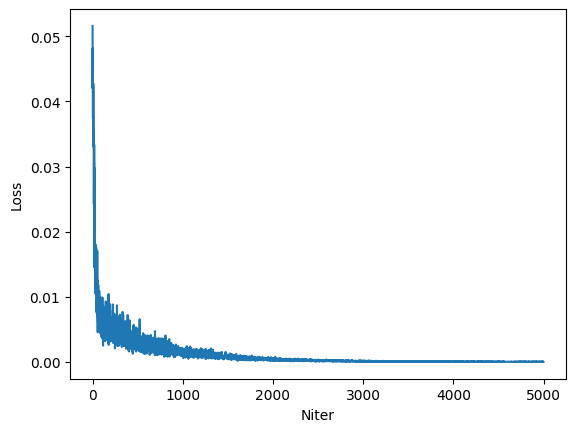

In [18]:
def train(network, optimizer, loss_fn, num_iters):
    """ Training function """
    loss_history = []

    for niter in range(1, num_iters + 1):
        optimizer.zero_grad()

        # 1) Sample 10 random inputs of shape [10, 3]
        x = torch.rand(10, 3)

        # 2) Forward the data through the network
        y_ = network(x)

        # 3) Compute loss wrt zero labels
        loss = loss_fn(y_, torch.zeros_like(y_))

        # 4) Backpropagation
        loss.backward()

        # Store the loss to plot
        loss_history.append(loss.item())

        # 5) Optimizer step
        optimizer.step()

        if niter % 50 == 0:
            print('Step {:2d} loss: {:.3f}'.format(niter, loss_history[-1]))

    plt.plot(loss_history)
    plt.xlabel('Niter')
    plt.ylabel('Loss')

net = MyNet()
# we will take stochastic gradient descent (SGD) to exemplify the training loop of a neural network
# We first need to handle the parameters that the optimizer will tune, and then we must specify the learning rate (lr) of each
# update step
opt = optim.SGD(net.parameters(), lr=0.01)
train(net, opt, loss_fn, 5000) #maybe we should iterate until finding the perfect number ? idk

We can compare the difference in output from a non-trained and the trained network

In [ ]:
# Generate 5 random samples of dimensionality 3
x_sample = torch.rand(5, 3)

# Forward the data through a non trained network
non_trained = MyNet()
print('Non-trained result: ', torch.mean(non_trained(x_sample)).item())

# Forward through the trained network (net)
print('Trained result: ', torch.mean(net(x_sample)).item())

print('Trained result should be closer to zero than the non-trained one (if training went well).')

### When we do NOT want gradients

There are some scenarios where we want to avoid building the `backward` graph, as we will not need gradients. For example, during inference/prediction/test. We can avoid the computation of gradients through the neural network forward pass by enclosing it into the `with torch.no_grad()` context (**which speeds up evaluation process by x2 or x3 normally**). As an example:

In [ ]:
x = torch.zeros(10, 3)
with torch.no_grad():
  y_ = net(x)
  loss = loss_fn(y_, torch.zeros(x.shape))
  print('Loss: {:.2f}'.format(loss))
  describe_tensor(loss, 'loss')
  print('NOTE THAT requires_grad=False NOW IN THE LOSS TENSOR')
  # This would crash: y.backward()


Finally, we can also cut the graph at any point we want (if we want) with the `.detach()` function of a `Tensor`. For instance, if we only wanted to train the output layer in the previous network (leaving the first layer `fc1` to behave randomly for whatever reason), we can re-define it as:

In [ ]:
class MyNetWithDetach(nn.Module):

  def __init__(self):
    super().__init__() # must call the superclass init first
    # First fully-connected layer (3 inputs, 20 hidden neurons)
    self.fc1 = nn.Linear(3, 20)
    # First hidden activation
    self.act1 = nn.Tanh()
    # Second fully-connected layer (20 hidden neurons, 3 outputs)
    self.fc2 = nn.Linear(20, 3)
    # No activation as we make it a linear output

  def forward(self, x):
    # activation of first layer is Tanh(FC1(x))
    h1 = self.act1(self.fc1(x))
    # DETACH
    h1 = h1.detach()
    # output activation
    y = self.fc2(h1)
    return y

# Now we can train this network
net = MyNetWithDetach()
# Now we can observe the difference of gradients in the biases of the 2 layers
# between this network and the regular one
# in terms of computed gradients

def forward_backward(network, net_name=''):
  x = torch.zeros(10, 3)
  y_ = network(x)
  loss = loss_fn(y_, torch.zeros(x.shape))
  loss.backward()
  describe_tensor(network.fc1.bias, '{}:FC1 bias'.format(net_name))
  describe_tensor(network.fc2.bias, '{}:FC2 bias'.format(net_name))

# Try with a non-detached network
forward_backward(MyNet(), 'Non-Detached Net')
# Try with a detached network
forward_backward(MyNetWithDetach(), 'Detached Net')


And you may wonder...

1. *Why would I cut the gradient flow at a certain point in my neural network? It looks like avoiding the learning process in some components. How may this be beneficial?* **A: Well, a neural network can be trained per blocks, as they are also tunnable feature extractors. Just bear in mind that you can bring a pre-trained neural network piece, attach it to your own additional piece, and tune only your own part of the network by freezing the first one**.

2. *What happens to the optimizer, which has the full list of parameters of my network, after I detach the graph?* **A: the optimizer still contains a reference to your parameters. So in the MyNetWithDetach case, it still has a reference to fc1 parameters. Nonetheless, as `.grad` is None, it simply cannot update the parameters.**


### References

[1] https://pytorch.org/tutorials/beginner/blitz/autograd_tutorial.html

[2] https://towardsdatascience.com/pytorch-autograd-understanding-the-heart-of-pytorchs-magic-2686cd94ec95

[3] https://ml-cheatsheet.readthedocs.io/en/latest/backpropagation.html